In [1]:
## import modules 

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter
import IPython.display as ipyd
import tensorflow as tf
from libs import utils, gif, datasets, dataset_utils, vae, dft, vgg16, nb_utils

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

#### Take a look at google's inception model V3

- the loading process has been codded in lib inception.py file 
- This network has been trained on ImageNet and its finaly output layer is a softmax layer denoting 1 of 1000 possible objects (+ 8 for unknown categories). This network is about only 50MB!

In [2]:
sess = tf.InteractiveSession()

#### 1. load inception model 

In [3]:
## load inception model 
from libs import inception

In [4]:
## load the inception model 
net = inception.get_inception_model()       ## it will download the model from internet
                                            ## you can actually specify version here e.g :
                                            # net = inception.get_inception_model(version='v3')
                                            # net = vgg16.get_vgg_model()
                                            # net = vgg16.get_vgg_face_model()
                                            # net = i2v.get_i2v_model()
                                            # net = i2v.get_i2v_tag_model()

In [5]:
## now let's take a look at the graph 
tf.import_graph_def(net['graph_def'], name='inception')   ## set the default graph to be inception graph 
g = tf.get_default_graph()

## use nb_utils to visualize graph, there is a whole section on how to use tensorflow board 
## you can look into it further 
nb_utils.show_graph(net['graph_def'])

#### 2. get the tensor for input and output 

In [6]:
## print the name of each process in the graph 
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print(names[:10])

['inception/input', 'inception/conv2d0_w', 'inception/conv2d0_b', 'inception/conv2d1_w', 'inception/conv2d1_b', 'inception/conv2d2_w', 'inception/conv2d2_b', 'inception/mixed3a_1x1_w', 'inception/mixed3a_1x1_b', 'inception/mixed3a_3x3_bottleneck_w']


In [7]:
## use get_tensor_by_name to get the input tensor and the output tensor 
## so that we can use them to do prediction 

input_name = names[0] + ':0'                     ## use name to get to the input tensor, we need to add 0 to the end, 
x = g.get_tensor_by_name(input_name)             ## it is just the way tf works, newly created node will be marked as 0
softmax = g.get_tensor_by_name(names[-1] + ':0') ## use name to ge to the output tensor, the output tensor
## we can name the output tensor whatever we want, 
## here because it is using softmax, so we just name it softmax

#### 3. Use these tensor to predict

0 255


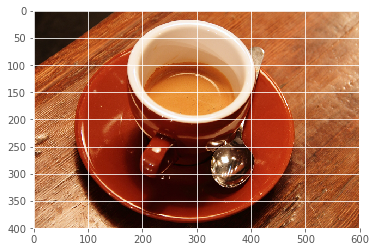

In [8]:
from skimage.data import coffee
og = coffee()              ## from skimage, get coffee picture
plt.imshow(og)
print(og.min(), og.max())  ## pixel value range

In [9]:
# Note that in the lecture, I used a slightly different inception
# model, and this one requires us to subtract the mean from the input image.
# The preprocess function will also crop/resize the image to 299x299
img = inception.preprocess(og)
print(og.shape), print(img.shape)
print(img.min(), img.max())        ## now, what left over is the variance

(400, 600, 3)
(299, 299, 3)
-117.0 138.0


image after preprocess

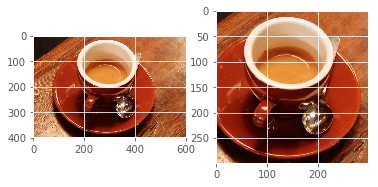

In [10]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(og)

# Note that unlike the lecture, we have to call the `inception.deprocess` function
# so that it adds back the mean!
axs[1].imshow(inception.deprocess(img))

- reshape image to 4D 
- As we've seen from the last session, our images must be shaped as a 4-dimensional shape describing the number of images, height, width, and number of channels. So our original 3-dimensional image of height, width, channels needs an additional dimension on the 0th axis.

In [11]:
#### reshape image from 3d to 4 d 
img_4d = img[np.newaxis]         ## this is how you add a dimention 
print(img_4d.shape)

(1, 299, 299, 3)


#### 4. Now we can run the prediction 

In [12]:
## run the predictio using softmax tensor, which is the output tensor, input is img_4d
res = np.squeeze(softmax.eval(feed_dict={x: img_4d}))